In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

In [5]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm just a computer program so I don't have feelings, but I'm here and ready to help. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 13, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl55GvK4jcVGnj3RXyiegEMUPnFjW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8dbf8bcb-942f-4efb-89ea-1f7d627a4fb7-0', usage_metadata={'input_tokens': 13, 'output_tokens': 31, 'total_tokens': 44, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langgraph.types import Command

In [7]:
from langgraph.prebuilt import create_react_agent

In [ ]:
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     Name:str
#     age:int
#     DOB:int

In [8]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply",update={"sum":result})

In [9]:
state={"num1":10,"num2":20}

In [10]:
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating one dummy multiagent

it is for network/collab multiagent

In [12]:
from langchain_core.tools import tool

In [45]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [46]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [15]:
llm_with_tool=llm.bind_tools([transfer_to_multiplication_expert])

In [16]:
response=llm_with_tool.invoke("hi")

In [17]:
response.content

'Hello! How can I assist you today?'

In [18]:
response.tool_calls

[]

In [19]:
response=llm_with_tool.invoke("what is 2 multiply 2?")

In [20]:
response.content

''

In [21]:
response.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_OtB8gzmR7XBlsyEFIYYrFkr7',
  'type': 'tool_call'}]

In [34]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

In [35]:
messages = [{"role": "system", "content": system_prompt}] + ["can you tell me the addition of 2 and 2?"]

In [36]:
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

In [29]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [ ]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [ ]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [67]:
graph=StateGraph(MessagesState)

In [68]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [69]:
graph.add_edge(START, "additional_expert")

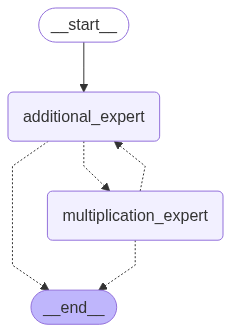

In [70]:
graph.compile()